In [1]:
import pandas as pd
import os
import boto3
import io
import numpy as np

In [57]:
bucket_name = "lneg-loka"
file_name = "patient_data_raw.csv"
processed_file_name = "patient_data_processed.csv"

In [3]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket_name, Key=file_name)
csv_string = obj['Body'].read().decode('utf-8')
df = pd.read_csv(io.StringIO(csv_string))

In [4]:
df

,patient_id,age,sex,bmi,smoker,diagnosis_code,medication_count,days_hospitalized,readmitted,last_lab_glucose,exercise_frequency,diet_quality,income_bracket,education_level,urban,albumin_globulin_ratio,chronic_obstructive_pulmonary_disease,alanine_aminotransferase
0,P00000,69,Male,25.3,No,D1,1,9,1,100.8,NaN,Average,Middle,Secondary,0,0.8934,B,25.4423
1,P00001,32,Male,27.0,Yes,D4,1,7,0,106.3,High,Good,High,Primary,1,0.7104,C,27.0529
2,P00002,89,Female,30.6,No,D1,2,9,0,138.4,NaN,Good,Middle,Tertiary,1,0.1078,B,30.4405
3,P00003,78,Male,17.8,Yes,D1,4,5,0,81.8,Low,Average,Low,Secondary,1,0.3754,C,17.5797
4,P00004,38,Female,37.7,No,D3,5,6,0,115.2,Low,Poor,Low,Primary,1,0.0994,D,37.7834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,P09995,88,Female,29.9,Yes,D1,8,3,1,104.0,NaN,Poor,Low,Primary,1,0.7400,B,30.0000
9996,P09996,43,Male,32.7,No,D5,2,4,0,69.5,Low,Average,Low,NaN,1,0.3098,C,32.6781
9997,P09997,63,Male,34.1,Yes,D2,4,9,1,78.0,Moderate,Good,High,Primary,1,0.8163,B,34.1534
9998,P09998,63,Female,28.0,No,D5,6,7,1,100.8,NaN,Average,Low,Primary,0,0.0544,A,28.0628


In [5]:
df['chronic_obstructive_pulmonary_disease'].unique()

array(['B', 'C', 'D', 'A'], dtype=object)

<Axes: >

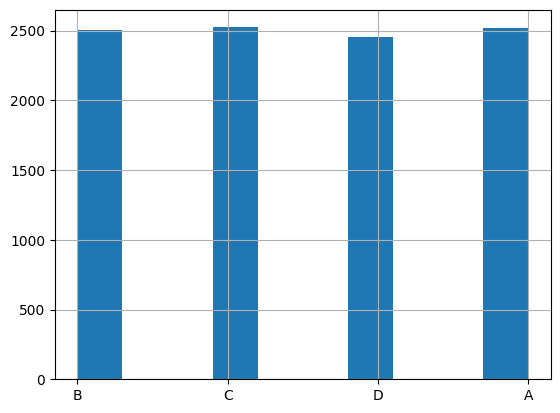

In [6]:
df['chronic_obstructive_pulmonary_disease'].hist()

In [7]:
df.isna().sum()

patient_id                                  0
age                                         0
sex                                         0
bmi                                         0
smoker                                      0
diagnosis_code                              0
medication_count                            0
days_hospitalized                           0
readmitted                                  0
last_lab_glucose                            0
exercise_frequency                       2012
diet_quality                                0
income_bracket                              0
education_level                          1040
urban                                       0
albumin_globulin_ratio                      0
chronic_obstructive_pulmonary_disease       0
alanine_aminotransferase                    0
dtype: int64

<Axes: >

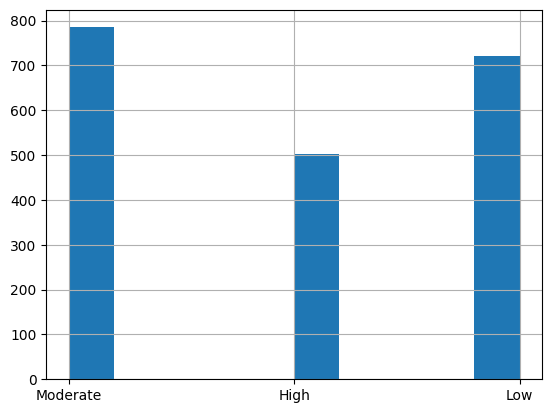

In [8]:
df.loc[df['chronic_obstructive_pulmonary_disease']=='A','exercise_frequency'].hist() #Plot class-conditional distribution of exercise_frequency for classes A, B, C and D. Beware, order of bins changes!

By plotting class-conditional distribution of 'exercise_frequency', it can be seen that it should have little predictive power for prediction chronic obstructive pulmonary disease - the distribution is virtually equal for all classes.

<Axes: >

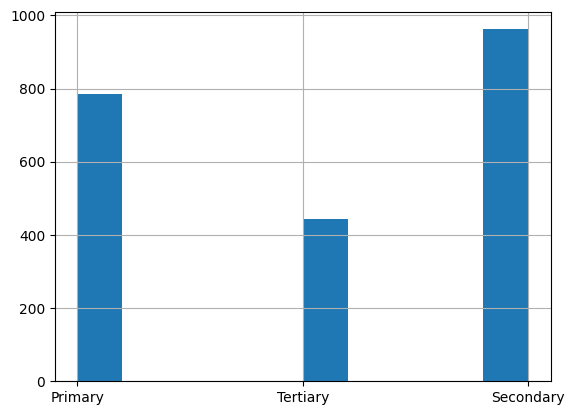

In [9]:
df.loc[df['chronic_obstructive_pulmonary_disease']=='D','education_level'].hist() #Plot class-conditional distribution of education_level for classes A, B, C and D. Beware, order of bins changes!

By plotting class-conditional distribution of 'education_level', it can be seen that it should have little predictive power for prediction chronic obstructive pulmonary disease - the distribution is virtually equal for all classes.

Since the distributions of educational_level and exercise_frequency are virtually class-independent, these features should have little predictive power for predicting chronc obstructive pulmonary disease. Because of this, I decided to discard these features instead of other more complex/wasteful solutions to deal with missing/NaN values.

In [10]:
df_new = df.copy()

In [11]:
df_new = df_new.drop('exercise_frequency',axis=1)
df_new = df_new.drop('education_level',axis=1)

In [12]:
df_new

,patient_id,age,sex,bmi,smoker,diagnosis_code,medication_count,days_hospitalized,readmitted,last_lab_glucose,diet_quality,income_bracket,urban,albumin_globulin_ratio,chronic_obstructive_pulmonary_disease,alanine_aminotransferase
0,P00000,69,Male,25.3,No,D1,1,9,1,100.8,Average,Middle,0,0.8934,B,25.4423
1,P00001,32,Male,27.0,Yes,D4,1,7,0,106.3,Good,High,1,0.7104,C,27.0529
2,P00002,89,Female,30.6,No,D1,2,9,0,138.4,Good,Middle,1,0.1078,B,30.4405
3,P00003,78,Male,17.8,Yes,D1,4,5,0,81.8,Average,Low,1,0.3754,C,17.5797
4,P00004,38,Female,37.7,No,D3,5,6,0,115.2,Poor,Low,1,0.0994,D,37.7834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,P09995,88,Female,29.9,Yes,D1,8,3,1,104.0,Poor,Low,1,0.7400,B,30.0000
9996,P09996,43,Male,32.7,No,D5,2,4,0,69.5,Average,Low,1,0.3098,C,32.6781
9997,P09997,63,Male,34.1,Yes,D2,4,9,1,78.0,Good,High,1,0.8163,B,34.1534
9998,P09998,63,Female,28.0,No,D5,6,7,1,100.8,Average,Low,0,0.0544,A,28.0628


<Axes: >

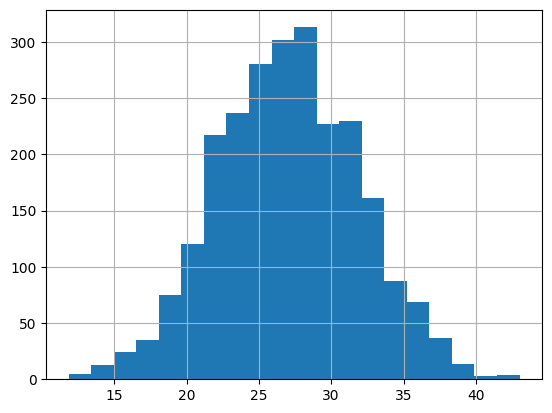

In [52]:
covariate_name = "alanine_aminotransferase"
target="D"
bins = df[df["chronic_obstructive_pulmonary_disease"]==target][covariate_name].unique()
bins.sort()
#df[df["chronic_obstructive_pulmonary_disease"]==target][covariate_name].value_counts().loc[bins].plot.bar() #use for categorical variables
df[df["chronic_obstructive_pulmonary_disease"]==target][covariate_name].hist(bins=20) #use for continuous real-valued variables

All variables have equal class-conditional distributions. Should not be possible to get meaningful predictions for chronic obstructive pulmonary disease from these features.
There's almost perfect collinearity between certain features, e.g. BMI and alanine_aminotransferase. Is the data of one of these features corrupted? In any case at least one of these should be dropped

In [ ]:
df_new = df_new.drop("alanine_aminotransferase",axis=1)

KeyError: "['alanine_aminotransferase'] not found in axis"

In [56]:
df_new

,patient_id,age,sex,bmi,smoker,diagnosis_code,medication_count,days_hospitalized,readmitted,last_lab_glucose,diet_quality,income_bracket,urban,albumin_globulin_ratio,chronic_obstructive_pulmonary_disease
0,P00000,69,Male,25.3,No,D1,1,9,1,100.8,Average,Middle,0,0.8934,B
1,P00001,32,Male,27.0,Yes,D4,1,7,0,106.3,Good,High,1,0.7104,C
2,P00002,89,Female,30.6,No,D1,2,9,0,138.4,Good,Middle,1,0.1078,B
3,P00003,78,Male,17.8,Yes,D1,4,5,0,81.8,Average,Low,1,0.3754,C
4,P00004,38,Female,37.7,No,D3,5,6,0,115.2,Poor,Low,1,0.0994,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,P09995,88,Female,29.9,Yes,D1,8,3,1,104.0,Poor,Low,1,0.7400,B
9996,P09996,43,Male,32.7,No,D5,2,4,0,69.5,Average,Low,1,0.3098,C
9997,P09997,63,Male,34.1,Yes,D2,4,9,1,78.0,Good,High,1,0.8163,B
9998,P09998,63,Female,28.0,No,D5,6,7,1,100.8,Average,Low,0,0.0544,A


In [60]:
buffer = io.StringIO()
df_new.to_csv(buffer)
s3.put_object(Bucket = bucket_name, Key = processed_file_name, Body = buffer.getvalue())

{'ResponseMetadata': {'RequestId': '7G7P03C4VEB4V40N',
  'HostId': '4OSrRWwl3ShetKyr+pCLWJitZgViwL2U8/mKzc0XnWNL+58qyZsUglxYVK7xnFewLzOrtiM2ipU=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '4OSrRWwl3ShetKyr+pCLWJitZgViwL2U8/mKzc0XnWNL+58qyZsUglxYVK7xnFewLzOrtiM2ipU=',
   'x-amz-request-id': '7G7P03C4VEB4V40N',
   'date': 'Sun, 12 Oct 2025 20:14:03 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"c71aedf39f26f15c79402d87d26b6c67"',
   'x-amz-checksum-crc32': 'zNGYfw==',
   'x-amz-checksum-type': 'FULL_OBJECT',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"c71aedf39f26f15c79402d87d26b6c67"',
 'ChecksumCRC32': 'zNGYfw==',
 'ChecksumType': 'FULL_OBJECT',
 'ServerSideEncryption': 'AES256'}